In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install spotipy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 236 kB 8.0 MB/s 
     |████████████████████████████████| 62 kB 1.5 MB/s 
     |████████████████████████████████| 140 kB 71.2 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0


In [ ]:
!pip install kneed

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MaxAbsScaler
import pickle
from sklearn.cluster import DBSCAN
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import tensorflow as tf  
from tensorflow import keras
from kneed.knee_locator import KneeLocator

In [ ]:
class Preprocessing:
  def __init__(self,train_link):
    self.__df = pd.read_csv(train_link)
    self.__pve_list = []
    self.__pca = 0
    self.__df_processed = 0
    self.__number_of_components = 0
    self.__scaler = 0


  def one_hot_encoding(self,dataframe):
    keys = dataframe["key"].to_numpy()
    keys = np.array(['A', 'A#', 'B','C','C#','D', 'D#','E', 'F','F#' ,'G',  'G#'])
    modes = dataframe["mode"].to_numpy()
    modes = np.array(["Major", "Minor"])
    
    index_key = []
    for i in keys:
      index_key.append(np.where(np.array(dataframe["key"])==i))
    
    index_mode = []
    for i in modes:
      index_mode.append(np.where(np.array(dataframe["mode"])==i))


    lis2 = np.zeros((len(keys),len(dataframe)))
    for j in range(0,len(index_key)):
      for i in index_key[j]:
        lis2[j][i]=1
    #df_copy2=df.copy().reset_index()

    dataframe_new2= pd.DataFrame(lis2).T
    dataframe_new2.columns= keys
    dataframe= pd.concat([dataframe,dataframe_new2],axis=1)
    dataframe = dataframe.drop(columns = "key")
    
    lis3 = np.zeros((2,len(dataframe)))
    for j in range(0,len(index_mode)):
      for i in index_mode[j]:
        lis3[j][i]=1
    #df_copy3=df.copy().reset_index()

    dataframe_new3= pd.DataFrame(lis3).T
    dataframe_new3.columns= modes
    dataframe= pd.concat([dataframe,dataframe_new3],axis=1)
    dataframe = dataframe.drop(columns = ["mode"])
    return dataframe
  def preprocess_train_shape(self):
    df = self.__df
    df = df.drop(["artist_name","track_name","track_id","genre"],axis=1)
    df = self.one_hot_encoding(df)
    List1= [0,1,3,4,5]
    List2 = np.unique(df["time_signature"].to_numpy())
    Dic = dict(zip(List2, List1))
    df=df.replace({"time_signature": Dic})
    self.__scaler = MinMaxScaler() #updated
    df[["popularity","duration_ms","tempo","loudness","time_signature"]] = self.__scaler.fit_transform(df[["popularity","duration_ms","tempo","loudness","time_signature"]])
    self.__df = df
    self.__df_processed = df
    
  def get_processed_df(self):
    return self.__df_processed

  def get_PCA_plot(self):
    df = self.__df_processed
    arr = df.to_numpy()
    self.__number_of_components = [x for x in range(1,26)]
    

    for component in self.__number_of_components:
      pca = PCA(n_components=component)
      pca.fit(arr)
      self.__pve_list.append(np.sum(pca.explained_variance_ratio_))

    return self.__number_of_components, self.__pve_list



  def get_PVE(self):
    for i in range(len(self.__pve_list)):
      print(f"Number of components:{self.__number_of_components[i]} -> PVE:{self.__pve_list[i]}")
    
  def preprocess_train(self):
    self.preprocess_train_shape()   
    #Apply PCA with 0.9 PVE
    arr = self.__df.to_numpy()
    self.__pca = PCA(0.9)
    self.__pca.fit(arr)
    transformed_arr = self.__pca.transform(arr)
    transformed_df = pd.DataFrame(data=transformed_arr,columns=[f"principal_componenet {x+1}" for x in range(transformed_arr.shape[1])])
    return transformed_df
  
  def preprocess_test(self,test):
    #self.preprocess_train()
    test = pd.read_csv(test)
    test = test.drop(columns=["Unnamed: 0"],axis=1)
    test = self.one_hot_encoding(test)
    test[["popularity","duration_ms","tempo","loudness","time_signature"]] = self.__scaler.transform(test[["popularity","duration_ms","tempo","loudness","time_signature"]])
    transformed_test = self.__pca.transform(test)
    test = pd.DataFrame(data=transformed_test,columns=[f"principal_componenet {x+1}" for x in range(transformed_test.shape[1])])
    test = test.mean()
    test = test.to_numpy()
    test = pd.DataFrame(data=test.reshape(1,15),columns=[f"principal_componenet {x+1}" for x in range(test.shape[0])])
    return test
  
  def call_playlist(self,link):
    #Authentication - without user
    client_credentials_manager = SpotifyClientCredentials(client_id="", client_secret="")
    sp = spotipy.Spotify(client_credentials_manager = client_credentials_manager)

    playlist_link = link
    playlist_URI = playlist_link.split("/")[-1].split("?")[0]
    track_uris = [x["track"]["uri"] for x in sp.playlist_tracks(playlist_URI)["items"]]
    keys = ["danceability","energy","loudness","speechiness","acousticness","instrumentalness","liveness","valence","tempo","duration_ms"]
    dictionary = {}
    for i in sp.audio_features(track_uris):
      for key in i:
        if key not in dictionary:
          dictionary[key] = []
        dictionary[key].append(i[key])
    df = pd.DataFrame.from_dict(dictionary)
    popularity=[]
    for track in sp.playlist_tracks(playlist_URI)["items"]:
        popularity.append(track["track"]["popularity"])

    df_pop = pd.DataFrame(popularity)
    df_pop.columns=["popularity"]
    df=pd.concat([df_pop,df],axis=1)
    df = df.drop(["type","id","uri","track_href","analysis_url"],axis = 1)  

    test = df.to_csv("test.csv") 
    return df

  def preprocess_test_AE(self,test):
    #self.preprocess_train()
    test = pd.read_csv(test)
    test = test.drop(columns=["Unnamed: 0"],axis=1)
    test = self.one_hot_encoding(test)
    test[["popularity","duration_ms","tempo","loudness","time_signature"]] = self.__scaler.transform(test[["popularity","duration_ms","tempo","loudness","time_signature"]])
    test = test.mean()
    test = test.to_frame().reset_index()
    test = pd.DataFrame(data=test[0].to_numpy().reshape(1,26),columns=[x for x in test["index"]])
    return test

  def preprocess_test_link_AE(self,link):
    test = self.call_playlist(link)
    test = self.one_hot_encoding(test)
    test[["popularity","duration_ms","tempo","loudness","time_signature"]] = self.__scaler.transform(test[["popularity","duration_ms","tempo","loudness","time_signature"]])
    test = test.mean()
    test = test.to_frame().reset_index()
    test = pd.DataFrame(data=test[0].to_numpy().reshape(1,26),columns=[x for x in test["index"]])
    return test

  def preprocess_test_link(self,link):
    test = self.call_playlist(link)
    test = self.one_hot_encoding(test)
    test[["popularity","duration_ms","tempo","loudness","time_signature"]] = self.__scaler.transform(test[["popularity","duration_ms","tempo","loudness","time_signature"]])
    transformed_test = self.__pca.transform(test)
    test = pd.DataFrame(data=transformed_test,columns=[f"principal_componenet {x+1}" for x in range(transformed_test.shape[1])])
    test = test.mean()
    test = test.to_numpy()
    test = pd.DataFrame(data=test.reshape(1,15),columns=[f"principal_componenet {x+1}" for x in range(test.shape[0])])
    return test

In [ ]:
df_original = pd.read_csv("/content/drive/MyDrive/CS464/Kod/SpotifyFeatures.csv")

In [ ]:
df_original.head()

,genre,artist_name,track_name,track_id,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
0,Movie,Henri Salvador,C'est beau de faire un Show,0BRjO6ga9RKCKjfDqeFgWV,0,0.611,0.389,99373,0.910,0.000,C#,0.3460,-1.828,Major,0.0525,166.969,4/4,0.814
1,Movie,Martin & les fées,Perdu d'avance (par Gad Elmaleh),0BjC1NfoEOOusryehmNudP,1,0.246,0.590,137373,0.737,0.000,F#,0.1510,-5.559,Minor,0.0868,174.003,4/4,0.816
2,Movie,Joseph Williams,Don't Let Me Be Lonely Tonight,0CoSDzoNIKCRs124s9uTVy,3,0.952,0.663,170267,0.131,0.000,C,0.1030,-13.879,Minor,0.0362,99.488,5/4,0.368
3,Movie,Henri Salvador,Dis-moi Monsieur Gordon Cooper,0Gc6TVm52BwZD07Ki6tIvf,0,0.703,0.240,152427,0.326,0.000,C#,0.0985,-12.178,Major,0.0395,171.758,4/4,0.227
4,Movie,Fabien Nataf,Ouverture,0IuslXpMROHdEPvSl1fTQK,4,0.950,0.331,82625,0.225,0.123,F,0.2020,-21.150,Major,0.0456,140.576,4/4,0.390


In [ ]:
dataframe = Preprocessing("/content/drive/MyDrive/CS464/Kod/SpotifyFeatures.csv")

In [ ]:
df = dataframe.preprocess_train_shape()

In [ ]:
df = dataframe.get_processed_df()
df.head()

,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,...,C#,D,D#,E,F,F#,G,G#,Major,Minor
0,0.00,0.611,0.389,0.015167,0.910,0.000,0.3460,0.900856,0.0525,0.642704,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.01,0.246,0.590,0.022029,0.737,0.000,0.1510,0.834469,0.0868,0.675801,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
2,0.03,0.952,0.663,0.027969,0.131,0.000,0.1030,0.686429,0.0362,0.325182,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.00,0.703,0.240,0.024747,0.326,0.000,0.0985,0.716695,0.0395,0.665238,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.04,0.950,0.331,0.012142,0.225,0.123,0.2020,0.557054,0.0456,0.518516,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


In [ ]:
test_1 = dataframe.preprocess_test_AE("/content/drive/MyDrive/CS464/Kod/test_test_pl_1.csv")
test_2 = dataframe.preprocess_test_AE("/content/drive/MyDrive/CS464/Kod/test_test_pl_2.csv")
test_3 = dataframe.preprocess_test_AE("/content/drive/MyDrive/CS464/Kod/test_pl3.csv")
test_4 = dataframe.preprocess_test_AE("/content/drive/MyDrive/CS464/Kod/test_sanat_muzigi.csv")
test_5 = dataframe.preprocess_test_AE("/content/drive/MyDrive/CS464/Kod/test_ucuncu_yeniler.csv")
test_6 = dataframe.preprocess_test_AE("/content/drive/MyDrive/CS464/Kod/test_metal.csv")
test_7 = dataframe.preprocess_test_AE("/content/drive/MyDrive/CS464/Kod/test_dylan.csv")
test_7

<ipython-input-5-7ac2e5e2d692>:19: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  index_key.append(np.where(np.array(dataframe["key"])==i))
<ipython-input-5-7ac2e5e2d692>:23: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  index_mode.append(np.where(np.array(dataframe["mode"])==i))
<ipython-input-5-7ac2e5e2d692>:19: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  index_key.append(np.where(np.array(dataframe["key"])==i))
<ipython-input-5-7ac2e5e2d692>:23: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  index_mode.append(np.where(np.array(dataframe["mode"])==i))
<ipython-input-5-7ac2e5e2d692>:19: FutureWarning: elementwise comparison failed; returning scalar instead, but i

,popularity,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,...,C#,D,D#,E,F,F#,G,G#,Major,Minor
0,0.450328,0.526902,0.400423,0.695157,0.050856,0.578262,0.009645,0.160203,0.497984,0.433925,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
x_train = df.to_numpy()
print(x_train.shape)
print(x_train.min(axis=0))
print(x_train.max(axis=0))

(232725, 26)
[0.00e+00 0.00e+00 5.69e-02 0.00e+00 2.03e-05 0.00e+00 9.67e-03 0.00e+00
 2.22e-02 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00
 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00
 0.00e+00 0.00e+00]
[1.    0.996 0.989 1.    0.999 0.999 1.    1.    0.967 1.    1.    1.
 1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.
 1.    1.   ]


#**Training**

In [ ]:
#https://machinelearningmastery.com/autoencoder-for-classification/
n_inputs = 26
visible = keras.layers.Input(shape=(n_inputs,))
# encoder level 1
e = keras.layers.Dense(n_inputs*2)(visible)
e = keras.layers.BatchNormalization()(e)
e = keras.layers.LeakyReLU()(e)
# encoder level 2
e = keras.layers.Dense(n_inputs)(e)
e = keras.layers.BatchNormalization()(e)
e = keras.layers.LeakyReLU()(e)
# bottleneck
n_bottleneck = 15
bottleneck = keras.layers.Dense(n_bottleneck)(e)
# define decoder, level 1
d = keras.layers.Dense(n_inputs)(bottleneck)
d = keras.layers.BatchNormalization()(d)
d = keras.layers.LeakyReLU()(d)
# decoder level 2
d = keras.layers.Dense(n_inputs*2)(d)
d = keras.layers.BatchNormalization()(d)
d = keras.layers.LeakyReLU()(d)
# output layer
output = keras.layers.Dense(n_inputs, activation='sigmoid')(d)
# define autoencoder model
model = keras.models.Model(inputs=visible, outputs=output)
# compile autoencoder model
opt = keras.optimizers.Adam(learning_rate=0.0063)
model.compile(optimizer=opt, loss='mse')
history = model.fit(x_train,
x_train,
epochs=50, 
batch_size=64, validation_split=0.1)
#save autoencoder model
model.save("/content/drive/MyDrive/CS464/Kod/autoencoder_model.h5")

Epoch 1/50
3273/3273 [==============================] - 16s 4ms/step - loss: 0.0025 - val_loss: 8.0804e-04
Epoch 2/50
3273/3273 [==============================] - 10s 3ms/step - loss: 8.3937e-04 - val_loss: 4.4672e-04
Epoch 3/50
3273/3273 [==============================] - 10s 3ms/step - loss: 6.0238e-04 - val_loss: 4.5313e-04
Epoch 4/50
3273/3273 [==============================] - 10s 3ms/step - loss: 4.8184e-04 - val_loss: 2.6254e-04
Epoch 5/50
3273/3273 [==============================] - 10s 3ms/step - loss: 4.0765e-04 - val_loss: 1.6147e-04
Epoch 6/50
3273/3273 [==============================] - 10s 3ms/step - loss: 3.6022e-04 - val_loss: 1.5791e-04
Epoch 7/50
3273/3273 [==============================] - 10s 3ms/step - loss: 3.5242e-04 - val_loss: 1.8480e-04
Epoch 8/50
3273/3273 [==============================] - 10s 3ms/step - loss: 3.2689e-04 - val_loss: 2.4867e-04
Epoch 9/50
3273/3273 [==============================] - 10s 3ms/step - loss: 3.2789e-04 - val_loss: 2.8018e-04
Epoch

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 26)]              0         
                                                                 
 dense (Dense)               (None, 52)                1404      
                                                                 
 batch_normalization (BatchN  (None, 52)               208       
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 52)                0         
                                                                 
 dense_1 (Dense)             (None, 26)                1378      
                                                                 
 batch_normalization_1 (Batc  (None, 26)               104       
 hNormalization)                                             

In [ ]:
#Encoder model
encoder = keras.Model(inputs=visible,outputs=bottleneck)
encoder.save("/content/drive/MyDrive/CS464/Kod/encoder_model.h5")

In [ ]:
training_loss = history.history['loss']
test_loss = history.history['val_loss']

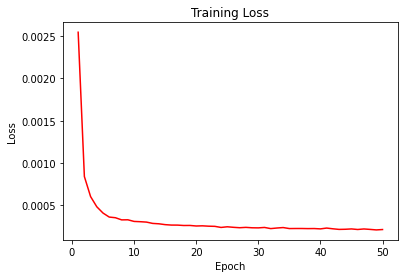

In [ ]:
epoch_count = range(1, len(training_loss) + 1)

# Visualize loss history
plt.plot(epoch_count, training_loss, 'r')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show();

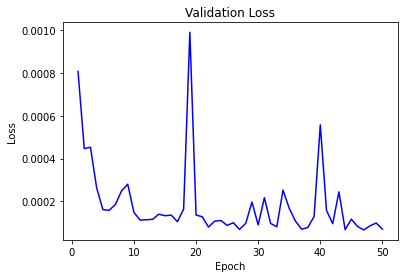

In [ ]:
plt.plot(epoch_count, test_loss, 'b')
plt.title('Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show();

#**Feature Reduction With Encoder**

In [ ]:
#Load the model
encoder = keras.models.load_model("/content/drive/MyDrive/CS464/Kod/encoder_model.h5",compile=False)

#26 --> 15
transformed_arr = encoder.predict(x_train)
print(x_train.shape)
print(transformed_arr.shape)

#Normalize transformed_arr
scaler = MinMaxScaler()
transformed_arr = scaler.fit_transform(transformed_arr)

#Save transformed_arr
with open('/content/drive/MyDrive/CS464/Kod/transformed_arr_encoder.pickle', 'wb') as f:
    pickle.dump(transformed_arr, f, protocol=pickle.HIGHEST_PROTOCOL)

7273/7273 [==============================] - 8s 1ms/step
(232725, 26)
(232725, 15)


# Feature Reduction for Tests

In [ ]:
def reduction(path,dataset,scaler):
  encoder = keras.models.load_model(path,compile=False)

  #26 --> 15
  arr = encoder.predict(dataset)
  print(dataset.shape)
  print(arr.shape)

  #Normalize transformed_arr

  arr = scaler.transform(arr)

  return arr

In [ ]:
test_1 = reduction("/content/drive/MyDrive/CS464/Kod/encoder_model.h5",test_1,scaler)
with open('/content/drive/MyDrive/CS464/Kod/test_1_encoder.pickle', 'wb') as f:
      pickle.dump(test_1, f, protocol=pickle.HIGHEST_PROTOCOL)

1/1 [==============================] - 0s 93ms/step
(1, 26)
(1, 15)


In [ ]:
#Save transformed_arr
test_1 = reduction("/content/drive/MyDrive/CS464/Kod/encoder_model.h5",test_1,scaler)
with open('/content/drive/MyDrive/CS464/Kod/test_1_encoder.pickle', 'wb') as f:
      pickle.dump(test_1, f, protocol=pickle.HIGHEST_PROTOCOL)
test_2 = reduction("/content/drive/MyDrive/CS464/Kod/encoder_model.h5",test_2,scaler)
with open('/content/drive/MyDrive/CS464/Kod/test_2_encoder.pickle', 'wb') as f:
      pickle.dump(test_2, f, protocol=pickle.HIGHEST_PROTOCOL)
test_3 = reduction("/content/drive/MyDrive/CS464/Kod/encoder_model.h5",test_3,scaler)
with open('/content/drive/MyDrive/CS464/Kod/test_3_encoder.pickle', 'wb') as f:
      pickle.dump(test_3, f, protocol=pickle.HIGHEST_PROTOCOL)
test_4 = reduction("/content/drive/MyDrive/CS464/Kod/encoder_model.h5",test_4,scaler)
with open('/content/drive/MyDrive/CS464/Kod/test_4_encoder.pickle', 'wb') as f:
      pickle.dump(test_4, f, protocol=pickle.HIGHEST_PROTOCOL)
test_5 = reduction("/content/drive/MyDrive/CS464/Kod/encoder_model.h5",test_5,scaler)
with open('/content/drive/MyDrive/CS464/Kod/test_5_encoder.pickle', 'wb') as f:
      pickle.dump(test_5, f, protocol=pickle.HIGHEST_PROTOCOL)
test_6 = reduction("/content/drive/MyDrive/CS464/Kod/encoder_model.h5",test_6,scaler)
with open('/content/drive/MyDrive/CS464/Kod/test_6_encoder.pickle', 'wb') as f:
      pickle.dump(test_6, f, protocol=pickle.HIGHEST_PROTOCOL)      
test_7 = reduction("/content/drive/MyDrive/CS464/Kod/encoder_model.h5",test_7,scaler)
with open('/content/drive/MyDrive/CS464/Kod/test_7_encoder.pickle', 'wb') as f:
      pickle.dump(test_7, f, protocol=pickle.HIGHEST_PROTOCOL)

1/1 [==============================] - 0s 95ms/step
(1, 26)
(1, 15)
1/1 [==============================] - 0s 96ms/step
(1, 26)
(1, 15)
1/1 [==============================] - 0s 148ms/step
(1, 26)
(1, 15)


1/1 [==============================] - 0s 90ms/step
(1, 26)
(1, 15)


1/1 [==============================] - 0s 84ms/step
(1, 26)
(1, 15)
1/1 [==============================] - 0s 84ms/step
(1, 26)
(1, 15)
1/1 [==============================] - 0s 91ms/step
(1, 26)
(1, 15)


#**Load Transformed Numpy Array**

In [ ]:
transformed_arr = None
with open('/content/drive/MyDrive/CS464/Kod/transformed_arr_encoder.pickle', 'rb') as f:
    transformed_arr=pickle.load(f)

#**k-Means**

In [ ]:
number_of_clusters = [n for n in range(50,1050,50)]
inertias = []
silhouttes = []

for n in number_of_clusters:
  model = KMeans(n_clusters=n).fit(transformed_arr)
  labels = model.labels_
  inertias.append(model.inertia_)
  score = silhouette_score(transformed_arr,labels,metric="euclidean")
  print(f"Silhouette score for {n} clusters is {score}")
  silhouttes.append(score)

with open('/content/drive/MyDrive/CS464/Kod/kmeans_score_encoder.pickle', 'wb') as f:
    pickle.dump(silhouttes, f, protocol=pickle.HIGHEST_PROTOCOL)

with open('/content/drive/MyDrive/CS464/Kod/kmeans_inertia_encoder.pickle', 'wb') as f:
    pickle.dump(inertias, f, protocol=pickle.HIGHEST_PROTOCOL)

Silhouette score for 50 clusters is 0.13740766048431396
Silhouette score for 100 clusters is 0.12570853531360626
Silhouette score for 150 clusters is 0.12276644259691238
Silhouette score for 200 clusters is 0.12066846340894699
Silhouette score for 250 clusters is 0.11485336720943451
Silhouette score for 300 clusters is 0.11328677833080292
Silhouette score for 350 clusters is 0.10832993686199188
Silhouette score for 400 clusters is 0.10758445411920547
Silhouette score for 450 clusters is 0.10661894828081131
Silhouette score for 500 clusters is 0.10468748956918716
Silhouette score for 550 clusters is 0.10504918545484543
Silhouette score for 600 clusters is 0.10409732162952423
Silhouette score for 650 clusters is 0.10263945907354355
Silhouette score for 700 clusters is 0.10245420783758163
Silhouette score for 750 clusters is 0.1014217957854271
Silhouette score for 800 clusters is 0.10098271816968918
Silhouette score for 850 clusters is 0.1006646528840065
Silhouette score for 900 clusters 

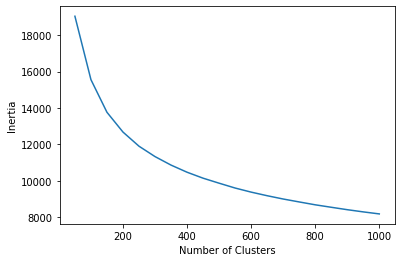

In [ ]:
plt.plot(number_of_clusters, inertias)
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")
plt.show()

In [ ]:
with open('/content/drive/MyDrive/CS464/Kod/kmeans_inertia.pickle', 'rb') as f:
    inertias=pickle.load(f)

knee_locator = KneeLocator(range(50,1050,50),inertias,curve="convex", direction="decreasing")
print(f"Elbow for the inertia graph is {knee_locator.elbow}")

Elbow for the inertia graph is 250


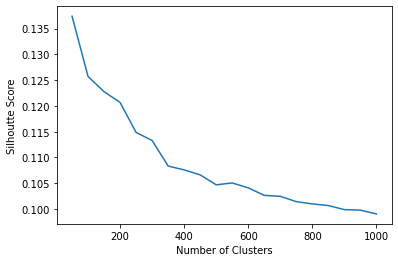

In [ ]:
plt.plot(number_of_clusters, silhouttes)
plt.xlabel("Number of Clusters")
plt.ylabel("Silhoutte Score")
plt.show()

In [ ]:
model = KMeans(n_clusters=1000).fit(transformed_arr)

In [ ]:
print(model.predict(test_1))
print(model.predict(test_2))
print(model.predict(test_3))
print(model.predict(test_4))
print(model.predict(test_5))
print(model.predict(test_6))
print(model.predict(test_7))

[477]
[458]
[477]
[567]
[458]
[458]
[567]


In [ ]:
df_with_clusters = df_original.copy()
df_with_clusters["cluster"] = model.labels_

In [ ]:
df_with_clusters[df_with_clusters["artist_name"] == "Metallica"][["artist_name","track_name","cluster"]]

,artist_name,track_name,cluster
153065,Metallica,Moth Into Flame,134
153069,Metallica,Holier Than Thou,355
153210,Metallica,The Four Horsemen (Remastered),404
153245,Metallica,The Thing That Should Not Be (Remastered),10
153696,Metallica,Fight Fire With Fire (Remastered),333
153797,Metallica,Until It Sleeps,527
153836,Metallica,"Atlas, Rise!",423
153842,Metallica,Of Wolf And Man,780
153862,Metallica,Orion (Remastered),925
153963,Metallica,The Memory Remains,464


In [ ]:
def recommend_song(playlist,model,df_with_clusters):
  playlist_cluster = model.predict(playlist)[0]
  df_filtered = df_with_clusters[df_with_clusters["cluster"] == playlist_cluster]
  song_rec = df_filtered.sample(10)
  return song_rec[["artist_name","track_name"]]

In [ ]:
recommend_song(test_1,model,df_with_clusters)

,artist_name,track_name
124457,Gustavo Santaolalla,The Last of Us (You and Me)
232165,Sarah Vaughan,Make Yourself Comfortable
198998,Christophe Beck,Thin Air - Score Demo
81477,Giacomo Puccini,"Tosca, SC 69, Act I: Ah! Finalmente! (Live)"
128660,Jacques Offenbach,"Les contes d'Hoffmann, Act II: Qu'as-tu donc? ..."
58499,Ruggero Leoncavallo,Pagliacci: Vesti la giubba
42471,Henry Jamison,True North
44414,Sleeping At Last,Total Eclipse of the Heart
183048,Idina Menzel,This Day / Walking by a Wedding
53868,Omar Kent Dykes,Since I Met You Baby


In [ ]:
from sklearn.metrics import mean_squared_error,r2_score

def eval(org,transformed):
  ind = np.argwhere(np.array(org.track_name)=="Make Yourself Comfortable")
  labels = pd.DataFrame(transformed).iloc[ind[0][0]].T.index
  values = pd.DataFrame(transformed).iloc[ind[0][0]].T.values

  return mean_squared_error(pd.DataFrame(test_1).T.values,values),r2_score(pd.DataFrame(test_1).T.values,values)

In [ ]:
print('Mean squared error of recomended song and test_1 playlist:', eval(df_original,transformed_arr,)[0])
print('R2 score of recomended song and test_1 playlist:',eval(df_original,transformed_arr,)[1])

Mean squared error of recomended song and test_1 playlist: 0.037186876
R2 score of recomended song and test_1 playlist: 0.1461558123561445


#**DBSCAN**

In [ ]:
#DBSCAN implementation

In [ ]:
#parameter tuning for eps varying from 0.35 to 0.62
df = transformed_arr
score_list2=[]
whole_turns = []
for eps in np.arange(0.20,0.32,0.02):
  clustering = DBSCAN(eps=eps, min_samples=30).fit(df)
  labels = clustering.labels_
  score = silhouette_score(df, labels)
  score_list2.append(score)
  whole_turns.append([eps,30]) 
  print(f"Silhouette score for {eps} eps is {score}")
max_score_index = score_list2.index(max(score_list2))
choice = whole_turns[max_score_index]
print('Best parameteres:','epsilon:',choice[0],'min_samples:',choice[1],'Silhoutte Score:',score_list2[max_score_index])         

Silhouette score for 0.2 eps is 0.14071626961231232
Silhouette score for 0.22 eps is 0.14815746247768402
Silhouette score for 0.24 eps is 0.15045613050460815
Silhouette score for 0.26 eps is 0.18002736568450928
Silhouette score for 0.27999999999999997 eps is 0.17303134500980377
Silhouette score for 0.29999999999999993 eps is 0.1592651605606079
Best parameteres: epsilon: 0.26 min_samples: 30 Silhoutte Score: 0.18002737


In [ ]:
with open('/content/drive/MyDrive/CS464/Kod/DBscan_autoencoder_scores.pickle', 'wb') as f:
    pickle.dump(scores, f, protocol=pickle.HIGHEST_PROTOCOL)


In [ ]:
scores = None
with open('/content/drive/MyDrive/CS464/Kod/DBscan_autoencoder_scores.pickle', 'rb') as f:
    scores=pickle.load(f)

In [ ]:
scores= scores[8:]

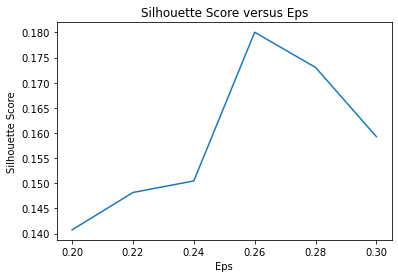

In [ ]:
plt.plot(np.arange(0.20,0.32,0.02),scores)
plt.xlabel("Eps")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score versus Eps")
plt.show()

In [ ]:
df =transformed_arr
dbscan_ae = DBSCAN(eps=0.26, min_samples=30).fit(df)


In [ ]:
silhouette_score(df, dbscan_ae.labels_)

0.18002737

In [ ]:
np.unique(dbscan_ae.labels_, return_counts=True)

(array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
        16, 17, 18, 19, 20, 21]),
 array([ 2955, 14971, 22857, 19997, 27208, 26042, 17128,  7358, 14923,
        23729, 15259, 22404, 17413,    80,    42,    49,    61,    32,
           38,    46,    63,    37,    33]))

In [ ]:
def dbscan_predict(model, X):

    nr_samples = X.shape[0]

    y_new = np.ones(shape=nr_samples, dtype=int) * -1

    for i in range(nr_samples):
        diff = model.components_ - X[:,i]  # NumPy broadcasting

        dist = np.linalg.norm(diff, axis=1)  # Euclidean distance

        shortest_dist_idx = np.argmin(dist)

        if dist[shortest_dist_idx] < model.eps:
            y_new[i] = model.labels_[model.core_sample_indices_[shortest_dist_idx]]

    return y_new

In [ ]:
test_1

array([[0.4469751 , 0.9117371 , 0.5252589 , 0.68267196, 0.72088015,
        0.48116484, 0.50216407, 0.533993  , 0.52475274, 0.5337517 ,
        0.6369729 , 0.4737097 , 0.35202044, 0.45236486, 0.3290493 ]],
      dtype=float32)

In [ ]:
y_pred_1 = (dbscan_predict(dbscan_ae,test_1))
y_pred_2 = (dbscan_predict(dbscan_ae,test_2))
y_pred_3 = (dbscan_predict(dbscan_ae,test_3))
y_pred_4 = (dbscan_predict(dbscan_ae,test_4))
y_pred_5 = (dbscan_predict(dbscan_ae,test_5))
y_pred_6 = (dbscan_predict(dbscan_ae,test_6))
y_pred_7 = (dbscan_predict(dbscan_ae,test_7))

In [ ]:
print(y_pred_1)
print(y_pred_2)
print(y_pred_3)
print(y_pred_4)
print(y_pred_5)
print(y_pred_6)
print(y_pred_7)

[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]


In [ ]:
y_pred_1=[-1]
y_pred_2=[-1]
y_pred_3=[-1]
y_pred_4=[-1]
y_pred_5=[-1]
y_pred_6=[-1]
y_pred_7=[-1]


In [ ]:
 #take 10 recommendations from the desired cluster
def cluster_items(model, pred):
  cluster_num=pred[0]

  if cluster_num==-1:
      cluster_count = np.unique(model.labels_, return_counts=True)[1][0]
      song_rec=[]
      indexes = pd.DataFrame(np.argwhere(model.labels_==cluster_num))
      for i in range(0,len(indexes)):
        index = np.argwhere(model.labels_==cluster_num)[i][0]
        song_rec.append(np.array((df_original.iloc[index:index+1,1:3])))
      song_rec =pd.DataFrame(np.array(song_rec).reshape(cluster_count,2),columns=["artist_name","track name"])
      last_recomend = song_rec.sample(n=10)
  else:
    cluster_count = np.unique(model.labels_, return_counts=True)[1][pred[0]]
    song_rec=[]
    indexes = pd.DataFrame(np.argwhere(model.labels_==cluster_num))
    for i in range(0,len(indexes)):
      index = np.argwhere(model.labels_==cluster_num)[i][0]
      song_rec.append(np.array((df_original.iloc[index:index+1,1:3])))
    song_rec =pd.DataFrame(np.array(song_rec).reshape(cluster_count,2),columns=["artist_name","track name"])
    last_recomend = song_rec.sample(n=10)

  return last_recomend

In [ ]:
song_rec_1 =cluster_items(dbscan_ae,y_pred_1)
song_rec_2 =cluster_items(dbscan_ae,y_pred_2)
song_rec_3 =cluster_items(dbscan_ae,y_pred_3)
song_rec_4 =cluster_items(dbscan_ae,y_pred_4)
song_rec_5 =cluster_items(dbscan_ae,y_pred_5)
song_rec_6 =cluster_items(dbscan_ae,y_pred_6)
song_rec_7 =cluster_items(dbscan_ae,y_pred_7)

In [ ]:
song_rec_1

,artist_name,track name
1885,Justin Hurwitz,Sextant
2453,grandson,Kiss Bang
1558,Lagwagon,Sleep
2305,Rodrigo y Gabriela,Tamacun - Remastered
1096,Franz Schubert,"Introduction & Variations on ""Trockne Blumen"",..."
628,Ibrary's Children's Music & Stories,The Walrus and the Carpenter
1983,Idina Menzel,Marvin's Long Lost Brother
2151,John Williams,Meeting Aragog
2019,Hayley Mills,Edward's Problem
1382,Ludwig van Beethoven,Fur Elise


In [ ]:
(df_original.sample(n=1)).track_name.values[0]

'Honeypot'

In [ ]:
from sklearn.metrics import mean_squared_error,r2_score

def eval(rec_songs,org,transformed):
  ind = np.argwhere(np.array(org.track_name)==(rec_songs.sample(n=1)).track_name.values[0])
  labels = pd.DataFrame(transformed).iloc[ind[0][0]].T.index
  values = pd.DataFrame(transformed).iloc[ind[0][0]].T.values

  return mean_squared_error(pd.DataFrame(test_1).T.values,values),r2_score(pd.DataFrame(test_1).T.values,values)

In [ ]:
print('Mean squared error of recomended song and test_1 playlist:', eval(song_rec_1,df_original,transformed_arr,)[0])
print('R2 score of recomended song and test_1 playlist:',eval(df_original,df_original,transformed_arr,)[1])

Mean squared error of recomended song and test_1 playlist: 0.046455577
R2 score of recomended song and test_1 playlist: -0.06666187076917929


In [ ]:
song_rec_2

,artist_name,track name
1553,Rancid,Telegraph Avenue
1368,Frédéric Chopin,"Etude in A flat major, Op. posthumous No. 3"
1307,Haken,1985
1169,Richard Wagner,"Die Walküre, WWV 86B, Act II: So sah ich Siegv..."
1977,Randy Newman,Alternate Cue 4
2428,Anouar Brahem,Bahia
1142,Francesco Cilea,L'arlesiana: Lamento di Federico
773,Radha,One Potato
678,Kimbo Children's Music,Battements Frappes: The Ragtime Dance
1214,Ski Mask The Slump God,WTF!?


In [ ]:
song_rec_3

,artist_name,track name
1851,Snarky Puppy,Flood
1970,Solange,Not Screwed! (interlude)
112,DJ Shadow,Changeling
1235,George Frideric Handel,"Rinaldo, HWV 7a, Act I (Ed. G. Sechi): Questi ..."
1534,Miguel,Come Through and Chill
1466,Scott Hamilton,Bésame Mucho (Live)
1398,Jóhann Jóhannsson,Dive-Bomb Blues
1454,The National,Demons
970,Kehlani,Feels
2125,John Williams,A Window to the Past


In [ ]:
song_rec_4

,artist_name,track name
2196,Lorne Balfe,Labored and Lost
1688,Eddie Izzard,Heimlich Maneouvre
1097,Pyotr Ilyich Tchaikovsky,"The Nutcracker, Op. 71, TH 14: 14c. Pas de deu..."
1889,Beth Fowler,Home (Reprise)
1735,Jeff Dunham,Three Radio Men and a Steek!
1403,Imrat Khan,Rag Miya Ki Todi
71,ZAYN,Too Much (feat. Timbaland)
186,Yoshihisa Hirano,Get Funky!
1464,Dean Martin,Ain't That A Kick In The Head
1845,Django Reinhardt,Tiger Rag


In [ ]:
song_rec_5

,artist_name,track name
1376,Edvard Grieg,"Lyric Pieces, Book 1, Op. 12: Arietta"
1924,Randy Newman,Waking Up
573,J. Cole,Love Yourz
951,Mndsgn,Fif Dim
1780,Donnell Rawlings,School
1163,Giuseppe Verdi,Nabucco / Act 2: S'oda or me
883,Richard Wagner,"Siegfried, WWV 86C, Act II (Highlights): Aber ..."
486,Yves Prin,Tango Fusion
2119,Randy Crawford,Your Precious Love
1241,George Frideric Handel,"Rinaldo, HWV 7a, Act I (Ed. G. Sechi): Al nimi..."


In [ ]:
song_rec_6

,artist_name,track name
84,Mike Perry,Rocksteady
242,Kai Wachi,Damage
2147,Daniel Pemberton,Miles Morales Returns
994,The White Stripes,Fell In Love With A Girl
159,Kensuke Ushio,mon
767,Enzo Garcia,Jack-O-Lantern
581,Bone Thugs-N-Harmony,Foe Tha Love of $
773,Radha,One Potato
895,Richard Wagner,"Das Rheingold, WWV 86A, Scene 1: Nur wer der M..."
2084,Michel Roux,Les aventures d'Arsène Lupin: Le bouchon de cr...


In [ ]:
song_rec_7

,artist_name,track name
467,Oliver Wallace,"Plotting a Pixie's Plight - From ""Peter Pan""/S..."
2336,MC YOGI,Heart Sutra
865,Francesco Cavalli,"Cavalli: La virtù de' strali d'Amore, Act 2: ""..."
328,Nobuo Uematsu,"Flowers Blooming in the Church (From ""Final Fa..."
1482,Oscar D'León,En Tu Busca
191,Nobuo Uematsu,Mystic Mysidia
283,Justice,Phantom Part 1.5 - Live Version
64,Yo La Tengo,You Can Have It All
1491,Proleter,Faidherbe Square
1067,Johann Sebastian Bach,"St. Matthew Passion, BWV 244, Pt. 1: No. 24, U..."
